In [ ]:
# Import important libraries
import sys
import pandas as pd
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
!unzip "/content/drive/MyDrive/Arabic.zip"

In [ ]:
# Convert Labels from Excel file into Lists 
train_df = pd.read_csv("/content/csvTrainLabel 13440x1.csv")
test_df = pd.read_csv("/content/csvTestLabel 3360x1.csv")

train_labels = train_df.loc[:,"1"].tolist()
train_labels.insert(0,1)

test_labels = test_df.loc[:,"1"].tolist()
test_labels.insert(0,1)


In [ ]:
# Get alphanuemerical ordering of image file paths
file_walk = os.walk("/content/train images 13440x32x32")
result = [os.path.join(root, file) for root, dir, files in file_walk for file in files]
result = sorted(result)

In [ ]:
# Reorder our train labels alphanuemerically
train_labels_string = []
for i in range(len(train_labels)):
  train_labels_string.append(str(i+1) + ":" + str(train_labels[i]))
print(train_labels_string)
train_labels_string = sorted(train_labels_string)
print(train_labels_string)

train_labels_v2 = []
for i in range(len(train_labels_string)):
  train_labels_v2.append(int(train_labels_string[i].split(":")[1]))
train_labels = train_labels_v2
for i in range(len(train_labels)):
  train_labels[i] = train_labels[i] - 1

In [ ]:
# Reorder our train labels alphanuemerically
test_labels_string = []
for i in range(len(test_labels)):
  test_labels_string.append(str(i+1) + ":" + str(test_labels[i]))
test_labels_string = sorted(test_labels_string)
test_labels_v2 = []
for i in range(len(test_labels_string)):
  test_labels_v2.append(int(test_labels_string[i].split(":")[1]))
test_labels = test_labels_v2
for i in range(len(test_labels)):
  test_labels[i] = test_labels[i] - 1


In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm

# Data preprocessing with Keras

train_dir = "/content/train images 13440x32x32"
test_dir = "/content/test images 3360x32x32"
batch_size = 32;
img_height = 150; 
img_width = 150;

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = train_labels,
    label_mode = "int",
    color_mode= "rgb",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels = test_labels,
    label_mode = "int",
    color_mode= "rgb",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)


Found 13440 files belonging to 1 classes.
Found 3360 files belonging to 1 classes.


In [ ]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


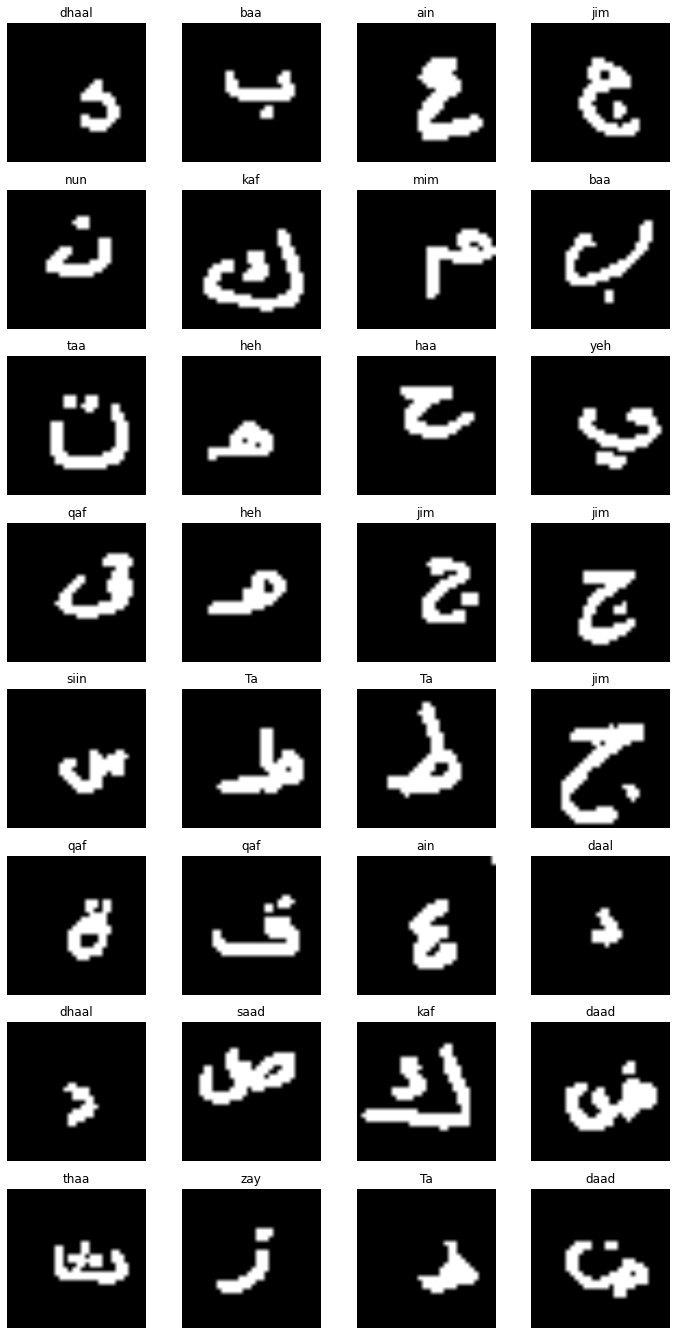

In [ ]:
# Display our data with its labels 
letters = ['alif', 'baa', 'taa', 'thaa', 'jim', 'haa', 'khaa', 'daal', 'dhaal', 'raa', 'zay',
              'siin', 'shiin', 'saad', 'daad', "Ta", "Dha", "ain", "ghain", "feh", "qaf", "kaf", "lam", "mim",
              "nun", "heh", "wa", "yeh"]
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(letters[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# Construct a convolutional nueral-network
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model_1 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[150, 150, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=28, activation='softmax'),
])

In [ ]:
from keras import backend as K
optimizer = keras.optimizers.SGD(learning_rate = 0.0001)
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_1.fit(train_ds, epochs=2, validation_data= test_ds, callbacks=[model_checkpoint_callback])
K.set_value(model_1.optimizer.learning_rate, 0.00005)
model_1.fit(train_ds, epochs=3, validation_data= test_ds, callbacks=[model_checkpoint_callback])

Epoch 1/2
420/420 [==============================] - 57s 134ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.4581 - val_accuracy: 0.9104
Epoch 2/2
420/420 [==============================] - 60s 144ms/step - loss: 0.0191 - accuracy: 0.9928 - val_loss: 0.4568 - val_accuracy: 0.9107
Epoch 1/3
420/420 [==============================] - 59s 139ms/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 0.4625 - val_accuracy: 0.9110
Epoch 2/3
420/420 [==============================] - 60s 142ms/step - loss: 0.0177 - accuracy: 0.9940 - val_loss: 0.4611 - val_accuracy: 0.9113
Epoch 3/3
420/420 [==============================] - 60s 142ms/step - loss: 0.0178 - accuracy: 0.9935 - val_loss: 0.4618 - val_accuracy: 0.9116


In [ ]:
K.set_value(model_1.optimizer.learning_rate, 0.001)
model_1.fit(train_ds, epochs=2, validation_data= test_ds, callbacks=[model_checkpoint_callback])

Epoch 1/2
420/420 [==============================] - 76s 182ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.4746 - val_accuracy: 0.9095
Epoch 2/2
420/420 [==============================] - 77s 184ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.4782 - val_accuracy: 0.9092


In [ ]:
model_1.load_weights(checkpoint_filepath)

In [ ]:
model_1.evaluate(test_ds)

105/105 [==============================] - 7s 64ms/step - loss: 0.4618 - accuracy: 0.9116


[0.4618028998374939, 0.9116071462631226]

In [ ]:
model_1.save("ArabicCNN")

INFO:tensorflow:Assets written to: ArabicCNN/assets


In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model_1, "tfjsmodel")

In [ ]:
!zip -r /content/ArabicCNN.zip /content/ArabicCNN

In [ ]:
!zip -r /content/tfjsmodel.zip /content/tfjsmodel

In [ ]:
from google.colab import files
files.download("/content/ArabicCNN.zip")
files.download("/content/tfjsmodel.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>